# Import Required Libraries
This section imports the necessary libraries for data processing and model building.

In [24]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1) Read CSV Data
Load the training data from the CSV file and display basic information.

In [30]:
labeled_df = pd.read_csv("archive/train.csv")

# The 'id' column contains image file names, e.g., "00000.jpg"
# The 'has_cactus' column contains 0 or 1 (label)

print("Number of labeled data:", len(labeled_df))
print(labeled_df)

Number of labeled data: 17500
                                         id  has_cactus
0      0004be2cfeaba1c0361d39e2b000257b.jpg           1
1      000c8a36845c0208e833c79c1bffedd1.jpg           1
2      000d1e9a533f62e55c289303b072733d.jpg           1
3      0011485b40695e9138e92d0b3fb55128.jpg           1
4      0014d7a11e90b62848904c1418fc8cf2.jpg           1
...                                     ...         ...
17495  ffede47a74e47a5930f81c0b6896479e.jpg           0
17496  ffef6382a50d23251d4bc05519c91037.jpg           1
17497  fff059ecc91b30be5745e8b81111dc7b.jpg           1
17498  fff43acb3b7a23edcc4ae937be2b7522.jpg           0
17499  fffd9e9b990eba07c836745d8aef1a3a.jpg           1

[17500 rows x 2 columns]


Check for class unbalance:

In [31]:
labeled_df['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

# 2) Prepare Train & Validation Split
Split the dataset into training and validation sets for model evaluation.

In [36]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    labeled_df,
    test_size=0.4,
    random_state=42,
    stratify=labeled_df["has_cactus"]
)

print(f"Train size: {len(train_df)}, Temporary size: {len(temp_df)},")

validation_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["has_cactus"]
)

print(f"Validation size: {len(validation_df)}, Test size: {len(test_df)},")

Train size: 10500, Temporary size: 7000,
Validation size: 3500, Test size: 3500,


# 3) Image Data Generator
Use `ImageDataGenerator` for data augmentation and loading images from directories.

In [37]:
# Create the ImageDataGenerator objects that will be used to load the images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path to train images folder
train_dir = "archive/train/train/"
# path to test images folder
test_dir = "archive/test/test/"

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    target_size=(32, 32),   # image size
    batch_size=32,
    class_mode='raw',       # since our labels are 0/1, choose 'raw'
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    target_size=(32, 32),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=train_dir,
    x_col="id",
    y_col="has_cactus",
    target_size=(32, 32),
    batch_size=32,
    class_mode="raw",
    shuffle=False,
)

Found 10500 validated image filenames.
Found 3500 validated image filenames.
Found 3500 validated image filenames.


# 4) Build a Simple CNN Model
Define and compile a Convolutional Neural Network (CNN) model.

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # output 0/1
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

# 5) Training
Train the model for a specified number of epochs.

In [16]:
EPOCHS = 50

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Epoch 1/50
438/438 [==============================] - 5s 12ms/step - loss: 0.2870 - accuracy: 0.8877 - val_loss: 0.3973 - val_accuracy: 0.8471
Epoch 2/50
438/438 [==============================] - 4s 8ms/step - loss: 0.1838 - accuracy: 0.9333 - val_loss: 0.1921 - val_accuracy: 0.9334
Epoch 3/50
438/438 [==============================] - 3s 8ms/step - loss: 0.1555 - accuracy: 0.9424 - val_loss: 0.1319 - val_accuracy: 0.9491
Epoch 4/50
438/438 [==============================] - 3s 8ms/step - loss: 0.1542 - accuracy: 0.9419 - val_loss: 0.1656 - val_accuracy: 0.9371
Epoch 5/50
438/438 [==============================] - 3s 8ms/step - loss: 0.1225 - accuracy: 0.9535 - val_loss: 0.1818 - val_accuracy: 0.9297
Epoch 6/50
438/438 [==============================] - 3s 8ms/step - loss: 0.1287 - accuracy: 0.9525 - val_loss: 0.1354 - val_accuracy: 0.9551
Epoch 7/50
438/438 [==============================] - 3s 8ms/step - loss: 0.1036 - accuracy: 0.9628 - val_loss: 0.1509 - val_accuracy: 0.9443
Epoch

# 6) Evaluation / Visualization of Results (Optional)
Visualize the training and validation accuracy and loss.

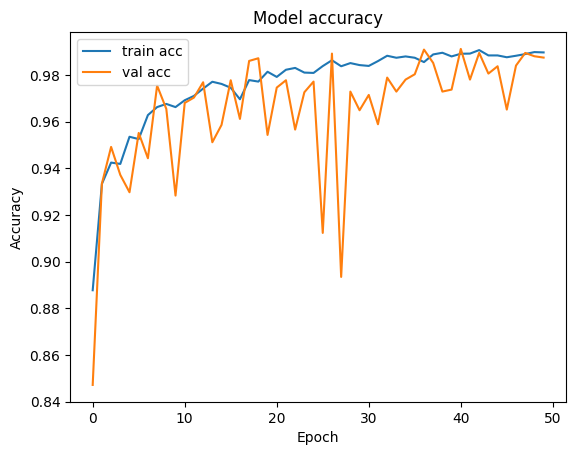

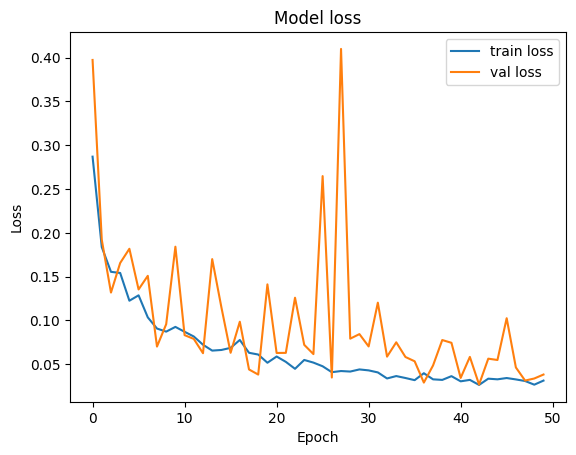

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7) Predict Test Data
Generate predictions for the test dataset.

In [12]:
test_filenames = sorted(os.listdir(test_dir))
# if there are files other than jpg images, filter them here

test_df = pd.DataFrame({"id": test_filenames})

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,  # no labels
    target_size=(32, 32),
    batch_size=32,
    class_mode=None,
    shuffle=False  # do not shuffle
)

preds = model.predict(test_generator)
# Since we use sigmoid in the output, preds values are in the range [0..1]
# We can use a threshold of 0.5
pred_labels = (preds > 0.5).astype(int).reshape(-1)

# Check the first 10 predictions
print("Example predictions on test data:")
for i in range(10):
    print(test_df.iloc[i]['id'], "->", pred_labels[i])

Found 4000 validated image filenames.
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Example predictions on test data:
000940378805c44108d287872b2f04ce.jpg -> 1
0017242f54ececa4512b4d7937d1e21e.jpg -> 1
001ee6d8564003107853118ab87df407.jpg -> 0
002e175c3c1e060769475f52182583d0.jpg -> 0
0036e44a7e8f7218e9bc7bf8137e4943.jpg -> 1
0038ed6f7417b8275b393307f66cb1e3.jpg -> 1
0059dfa41de4441fc23b9a4b98ba99cb.jpg -> 1
0061bd302d735db829418cb90b4e6040.jpg -> 1
00754573d8c7223e73da553dd43780bd.jpg -> 1
008d9fce71c8e03a4c9cdd15ea908573.jpg -> 0


# 8) Save Predictions (Optional)
Save the predictions to a CSV file for submission.

In [13]:
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "has_cactus": pred_labels
})
submission_df.to_csv("my_submission.csv", index=False)
print("\nFile 'my_submission.csv' has been saved successfully.")


File 'my_submission.csv' has been saved successfully.


In [16]:
#show the first 10 rows of the submission file
print("\nFirst 10 rows of the submission file:")
submission_df.head(10)


First 10 rows of the submission file:


,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1
5,0038ed6f7417b8275b393307f66cb1e3.jpg,1
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,1
7,0061bd302d735db829418cb90b4e6040.jpg,1
8,00754573d8c7223e73da553dd43780bd.jpg,1
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,0
